This notebook intended to calculate the correlation between percentage of inspections in the Park District, failed for specific feature, for example, litter, and number of litter-related 311 complains made in the window of N days before inspection for the related park

In [1]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
PARQA = os.getenv('PARQA')
path = PARQA + "data/Input/Parks_Data/PIP_InspectionMain.xlsx"

## Reading Data

In [3]:
df = pd.read_excel(path)

In [4]:
df = df[(pd.notnull(df.BeginInspection) ) &  (pd.notnull(df.EndInspection))]

## Parsing dates

In [5]:
df.head(2)

,Prop ID,Season,Round,Date,BeginInspection,EndInspection,Inspection Year,Overall Condition,Cleanliness,VisitorCount,Unacceptable Features,Inspection ID
0,M010-ZN08,Summer,2,2015-06-30,12:29:00,13:24:00,2015,A,A,60,SW,97371
1,M010-143,Summer,2,2015-06-30,13:40:00,13:57:00,2015,A,A,7,NaN,97370


In [6]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [7]:
# g = df[['Date','Prop ID','Overall Condition']].groupby('Prop ID').agg(lambda x: x.tolist()).reset_index()
# g.head(2)

In [8]:
def inRange(d, inspection, marginDays=7):
    '''tells if date is withing margin before the inspection'''
    return inspection - datetime.timedelta(days = marginDays) <=  d <= inspection

In [9]:
### ADD PROP ID to each call trhough calls
### aggregate Calls to Those ratings

In [10]:
inspections = df[['Prop ID','Date', 'Overall Condition', 'Cleanliness','Unacceptable Features']]


## Read matched Calls

In [11]:
lcalls = pd.read_csv(PARQA + 'data/311/311_rPID_litter.csv',index_col=0)[['rParkID','Created Date',]]

In [12]:
lcalls['Created Date'] = pd.to_datetime(lcalls['Created Date'])

In [13]:
lcalls.head()

,rParkID,Created Date
163,M219,2010-12-25 01:47:32
170,M042-ZN06,2010-12-23 15:30:49
228,M219,2010-12-20 11:08:40
229,X104-03,2010-12-20 10:36:16
230,X104-02,2010-12-20 10:36:16


In [14]:
def countCalls(z, d = 7):
    acalls = lcalls[lcalls.rParkID==z['Prop ID']]

    inD = lcalls['Created Date'].apply(lambda x: inRange(x,z.Date, marginDays=d))
#     print '!'
    return len(acalls[inD])

In [15]:
#### THIS TAKES TONS OF TIME: BEWARE!!  ########
cl_inspections = inspections[inspections['Cleanliness']=='U']

In [16]:
cl_inspections['weekCalls'] = cl_inspections.apply(countCalls, axis=1)

/Users/casy/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
#### THIS TAKES TONS OF TIME: BEWARE!!  ########
cl_inspections['monthCalls'] = cl_inspections.apply(lambda x: countCalls(x,d=30), axis=1)

/Users/casy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Aggregating to Districts

In [ ]:
# inspections['l_calls'] = inspections.apply(countCalls, axis=1)

In [ ]:
distrs = pd.read_csv(PARQA + '/data/PID_PDistr.csv', index_col=0)

In [ ]:
inspPerDistrict = pd.DataFrame(inspections.merge(distrs, how='left', on= 'Prop ID').distr.value_counts())
fInspPerDistrict = pd.DataFrame(cl_inspections.merge(distrs, how='left', on= 'Prop ID').distr.value_counts())

In [ ]:
callsPerDistrict = cl_inspections.merge(distrs, how='left', on='Prop ID')[['distr','monthCalls','weekCalls']].groupby('distr').agg(sum)

In [ ]:
r = pd.concat([cl_inspections, inspPerDistrict, fInspPerDistrict ],axis=1)

In [ ]:
r.columns = ['monthCalls','weekCalls','total','failed']
r['percent'] = 100.0*r.failed/r.total

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

r.plot(kind='scatter', x='percent',y='weekCalls',ax=axes[0],title='week', s=60);
r.plot(kind='scatter', x='percent',y='monthCalls',ax=axes[1],title='month', s=60);

axes[0].set_xlabel('failed inspections per district, %')
axes[1].set_xlabel('failed inspections per district, %')

axes[0].set_ylabel('complains in week before inspection')
axes[1].set_ylabel('complains in month before inspection')

plt.savefig(PARQA + 'parqa/Inspections/img/time_window.png')

## Litter specificly

In [18]:
litter = pd.read_csv(PARQA + "data/All_Inspections.csv",index_col=0)
litter = litter[litter.Litter==1]
litter.Date = pd.to_datetime(litter.Date, format='%Y-%m-%d')


In [19]:
litter.columns

Index([u'Prop ID', u'PropNum', u'Boro', u'GISBoro', u'District', u'Prop Name',
       u'Site Name', u'Prop Location', u'Site Location', u'ACRES', u'Category',
       u'Sub-Category', u'Comments', u'Rated', u'Reason Not Rated',
       u'Sub-Properties Rated', u'Sub-Property', u'COMMUNITYBOARD',
       u'TypeCategory', u'Season', u'Round', u'Date', u'BeginInspection',
       u'EndInspection', u'Inspection Year', u'Overall Condition',
       u'Cleanliness', u'VisitorCount', u'Unacceptable Features',
       u'Inspection ID', u'PID_base', u'Athletic Fields', u'Benches',
       u'Fences', u'Glass', u'Graffiti', u'Horticultural Areas', u'Ice',
       u'Lawns', u'Litter', u'Paved Surfaces', u'Play Equipment',
       u'Safety Surface', u'Sidewalks', u'Trails', u'Trees', u'Water Bodies',
       u'Weeds', u'Adjusted Acres', u'ZIPCODE'],
      dtype='object')

In [ ]:
litter.Cleanliness.value_counts()

A    5867
U    1862
N       1
Name: Cleanliness, dtype: int64

In [ ]:
litter['lweekCalls'] = litter.apply(countCalls, axis=1)
litter['monthCalls'] = litter.apply(lambda x: countCalls(x,d=30), axis=1)

In [ ]:
litter

In [150]:
failedLitterDistrict = pd.DataFrame(litter.merge(distrs, how='left', on= 'Prop ID').distr.value_counts())

In [153]:
lcallsPerDistrict = litter.merge(distrs, how='left', on='Prop ID')[['distr','monthCalls','lweekCalls']].groupby('distr').agg(sum)

In [159]:
d = pd.concat([lcallsPerDistrict, inspPerDistrict, failedLitterDistrict ],axis=1)
d.columns = ['monthCalls','weekCalls','total','failed']
d['percent'] = 100.0*d.failed/d.total

In [162]:
d.head(5)

,monthCalls,weekCalls,total,failed,percent
B-01,17,5,1403,276,19.672131
B-02,1,0,1066,188,17.636023
B-03,4,0,765,165,21.568627
B-04,0,0,357,83,23.249300
B-05,0,0,494,86,17.408907


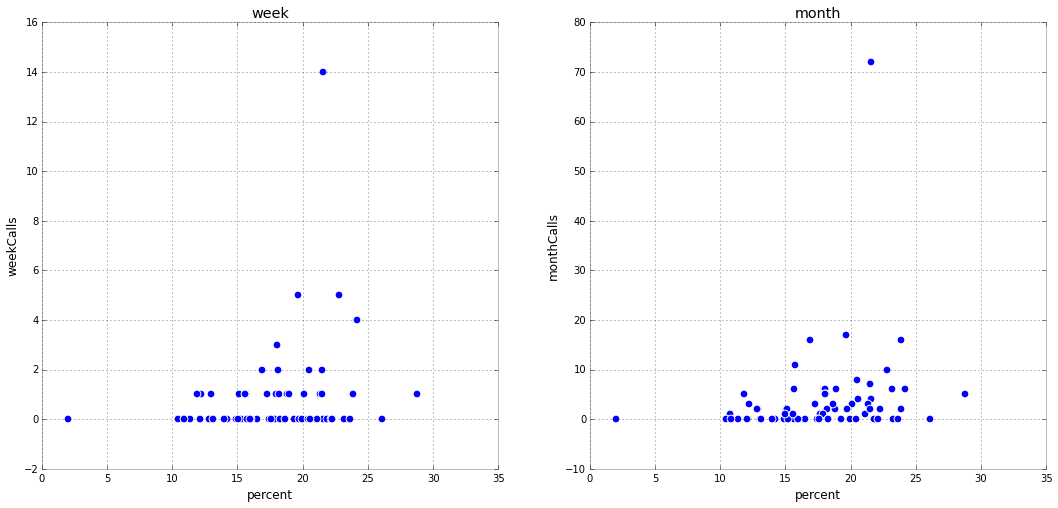

In [166]:
fig, axes = plt.subplots(1,2, figsize=(18,8))

d.plot(kind='scatter', x='percent',y='weekCalls',ax=axes[0],title='week', s=60);
d.plot(kind='scatter', x='percent',y='monthCalls',ax=axes[1],title='month', s=60);

axes[0].set_xlabel('failed litter inspections per district, %')
axes[1].set_xlabel('failed litter inspections per district, %')

axes[0].set_ylabel('litter complains in week before inspection')
axes[1].set_ylabel('litter complains in month before inspection')

plt.savefig(PARQA + 'parqa/Inspections/img/litter_time_window.png')